In [12]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib for plotting
import re # regular expressions

import warnings
warnings.filterwarnings("ignore") #because who likes annoying warnings

plt.style.use('ggplot') #prettier pictures

import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size

from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Set up the Data

In [2]:
df = pd.read_csv('../data/clean_train.csv')

In [3]:
#some datetime manipulations
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df['dropoff_datetime'] = pd.to_datetime(df.dropoff_datetime)
df['date'] = pd.to_datetime(df.date)

In [4]:
df['Hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['Month'] = df['pickup_datetime'].dt.month
df['dayofyear'] = df['pickup_datetime'].dt.dayofyear

Text(0.5, 1.0, 'Number of Rides over the Year')

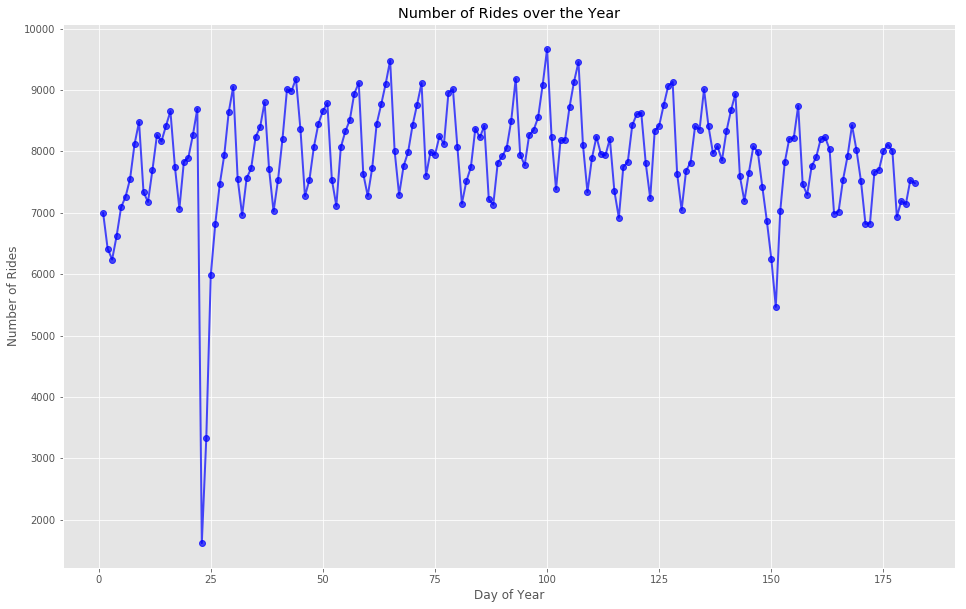

In [13]:
#plotting number of rides over the course of January to June

plt.plot(df.groupby('dayofyear').count()['id'], 'bo-', lw=2, alpha=0.7)
plt.xlabel('Day of Year')
plt.ylabel('Number of Rides')
plt.title('Number of Rides over the Year')

In [6]:
count =  df.groupby('dayofyear').count()['id']
ts = pd.DataFrame(({'day': count.index, 'count': count.values})).set_index('day')

# Time Series Data Exploration

In [7]:
#view the time series of number of rides per day
ts.head()

,count
day,
1,6993
2,6415
3,6238
4,6620
5,7088


In [8]:
#viewing the lagged time series, the first value becomes NaN
#the dataframe is shifted back one day
#the "tail" loses one last ts value from this lag

ts_lagged = ts.shift()
ts_lagged.head()

,count
day,
1,NaN
2,6993.0
3,6415.0
4,6238.0
5,6620.0


In [9]:
#view the difference between the ts and the lagged ts.

ts.diff().head()

,count
day,
1,NaN
2,-578.0
3,-177.0
4,382.0
5,468.0


Text(0.5, 1.0, 'Number of Rides over the Year')

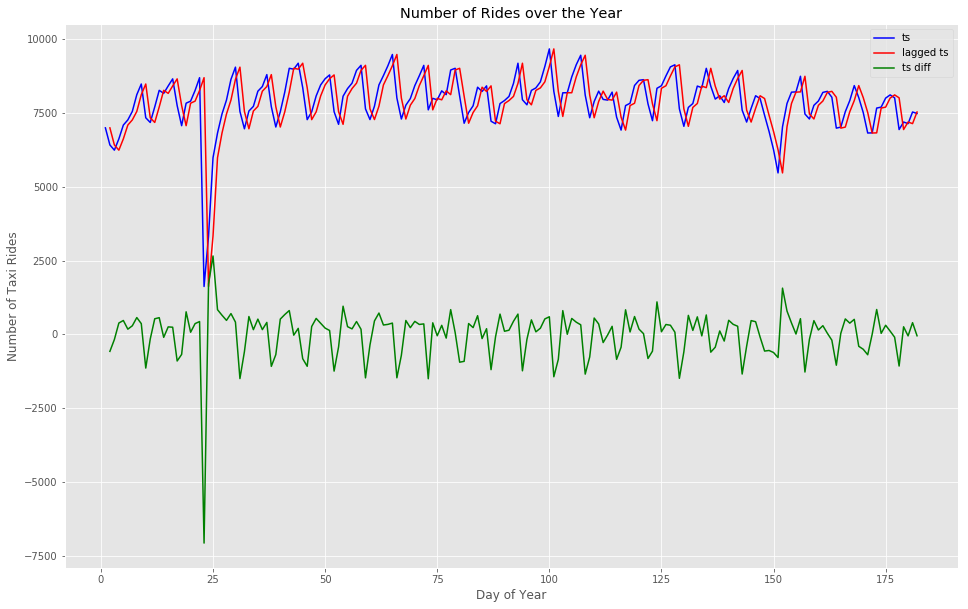

In [14]:
#view the three time series data on one plot

plt1 =  plt.plot(ts, color = 'blue', label = 'ts')
plt2 = plt.plot(ts_lagged, color = 'red', label = 'lagged ts')
plt3 = plt.plot(ts - ts_lagged, color = 'green', label = 'ts diff')
plt.legend()
plt.xlabel('Day of Year')
plt.ylabel('Number of Taxi Rides')
plt.title('Number of Rides over the Year')

**Exponentially weight moving average**

Ann exponential moving average is a type of infinite impulse response filter that applies weighting factors which decrease exponentially. Simply, recency matters in this EWMA model, as in the most recent data points matter the point in determining the time series values.

- notice that the EWMA does not lose the initial window of values

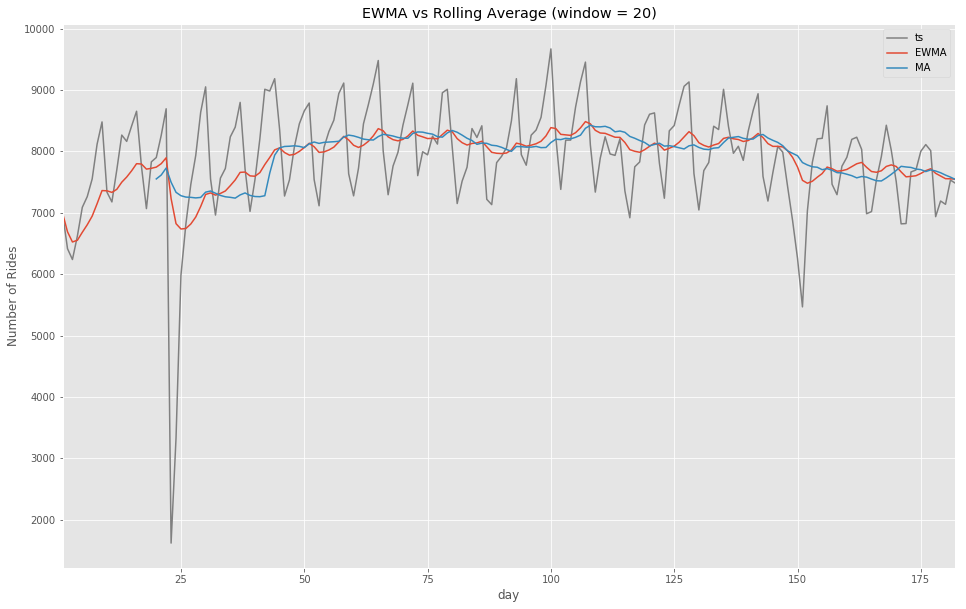

In [15]:
ts['count'].plot(color = 'gray', label = 'ts')
plt.plot(ts.ewm(span = 20,  min_periods = 0, adjust = True).mean(), label = 'EWMA')
plt.plot(ts.rolling(window = 20).mean(), label = 'Rolling Average')
plt.ylabel('Number of Rides')
plt.title('EWMA vs Rolling Average (window = 20)')
plt.legend()

# Time Series data relate to themselves

**auto-correlation function**

- Used to help identify possible structures of time series data
- Gives a sense of how different points in time relate to each other in a way explained by temporal distance

- Autocorrelation, also known as serial correlation, is the correlation of a signal with itself at different points in time. Informally, it is the similarity between observations as a function of the time lag between them.


In [16]:
from statsmodels.tsa import stattools

In [209]:
#create the log shifted time series

log_ts = np.log(ts)
log_ts_diff = log_ts - log_ts.shift()
log_ts_diff.dropna(inplace = True) #drop na values

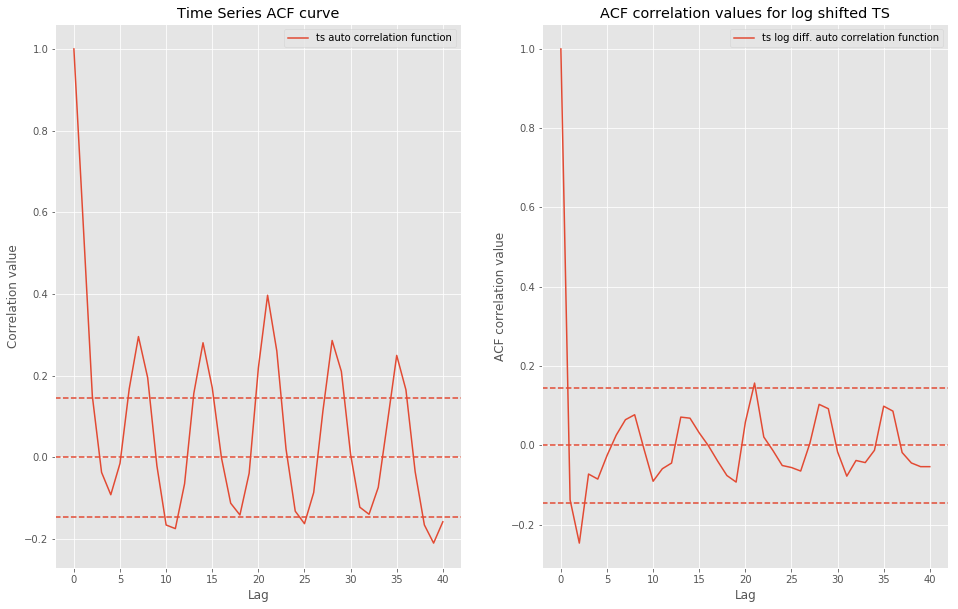

In [18]:
acf_result1 = stattools.acf(ts)
plt.subplot(1,2,1)
plt.plot(acf_result1, label = 'ts auto correlation function')
plt.axhline(y=0,linestyle='--')
#creating the 2 std dev dotted lines
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--')
plt.ylabel('Correlation value')
plt.xlabel('Lag')
plt.title('Time Series ACF curve')
plt.legend()


acf_result2 = stattools.acf(log_ts_diff)
plt.subplot(1,2,2)
plt.plot(acf_result2, label = 'ts log diff. auto correlation function')
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_ts_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_ts_diff)),linestyle='--')
plt.xlabel('Lag')
plt.ylabel('ACF correlation value')
plt.title('ACF correlation values for log shifted TS')
plt.legend()

**ACF for the regular time series** 

The auto correlation at delta = 0 should always be 1, since it is how the data point correlate with itself

For every other data point, the acf curve shows the correlation between the data point at that time with the data point that lags one time period behind it.

The ACF also shows us that the correlation values pops up out of the 95% confidence interval every (approx) 3.5 or half weeks. This recurrent structure tells us that we should de-trend the data. (weekly trends?)

This tells us that there is a very apparent trend every 7 days (and every multiple of 7 days, since this is periodic data), since the correlation function follows a very apparent trend. The Partial Autocorrelation function can make up for this "harmonic" trend in our periodic data by giving us the patial correlation of a time series with its own lagged values, controlling for the values of time series at all shorter lags.

Furthermore, we can use log and difference transformations to see if we can derive more insight from our data by de-trending the data towards stationarity (where the data, mean, and the variance is constant in time).

Since the data shows trends and seasonality, we need to remove it by detrending the data through logs and differences, moving average, linear regression, etc.

**ACF for the log differenced time series** 

Judging by the fact that over the course of the entire ACF values, we dont see a huge positive or negative values. We see this because for the most part, the number of taxi trips tended to stay about the same over the course of the year. We didn't see a huge drop (except for on January 23rd) or a huge increase in number of taxis taken per day. 

The internal structure of the count of taxis taken per day stays relatively the same over the year.

Stationary data would have a constant mean, varaiance and ACF. In other words the value, predictability, and structure is not drifting over time.

**Removing Seasonality**

- Simplest method: average the de-trended values for a specific season
- More Common method: use the 'loess' method (locally weighted scatterplot smoothing)

&nbsp; &nbsp; 1) Window of specified width is placed over the data <br>
&nbsp; &nbsp; 2) A weighted regression line or curve is fitted to the data, with points closest to the center of curve having greatest weight <br>
&nbsp; &nbsp; 3) Weighting is reduced on points farthest from regression line and calculation is rerun several times <br>
&nbsp; &nbsp; 4) This yields one point on the loess curve <br>

- Helps reduce the impact of outlier points, but is computationally taxing.


Checking for stationarity below on the log differenced time series data using the Augmented Dickey-Fuller test

In [19]:
from statsmodels.tsa.stattools import adfuller

useful_values_raw = adfuller(log_ts_diff['count'], autolag = 'AIC', regression = 'ct')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({ 'Value':useful_values, 'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%']})

,Value,Label
0,-9.262704e+00,Test Statistic
1,9.325540e-14,p-value
2,5.000000e+00,#Lags Used
3,1.750000e+02,Number of Observations Used
4,-4.011455e+00,Critical value for 1%
5,-3.435882e+00,Critical value for 5%
6,-3.141957e+00,Critical value for 10%


The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

Rejecting that there is a unit root -> time series is stationary

Since the pvalue is extremely close to 0, we can reject the null hypothesis and assume that the log difference transformation of the time series has detrended the data significantly enough that it can be considered as stationary.

  # Forecasting
  
  Since we've confirmed that our transformed data can now be considered to be stationary, we can move on to forecasting
  
  **AR + MA processes**
  
  - use PACF for AR model diagnostics
  - use ACF for MA model diagnostics

In [34]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    Source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

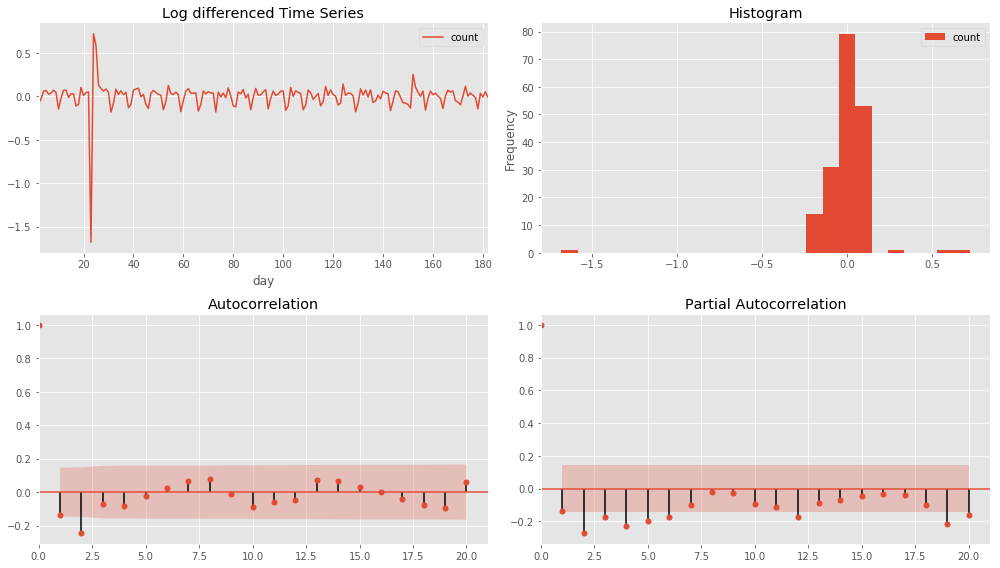

In [114]:
tsplot(log_ts_diff, title='Log differenced Time Series', lags=20);

The ACF shows that we most likely got rid of the seasonality fairly well, since we only have 1 correlation value outside of the confidence interval throughout the data set <br>
The PACF correlation values show us that for the most part, the time series values are negatively self correlated with its preceding values. 

**ARIMA model determination**

The table below summarize the patterns of the ACF and PACF associated with the $AR(p)$, $MA(q)$, and $ARMA(p,q)$ processes:

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(p)**     |    tails off         | cutoff after lag $p$ |
| **MA(q)**     | cutoff after lag $q$ |    tails off         |
| **ARMA(p,q)** |    tails off         |    tails off         |

Looking at the subplots above, it may be wise to use the AR models since it best describes our time series behavior.

In [21]:
from statsmodels.tsa.arima_model import ARIMA

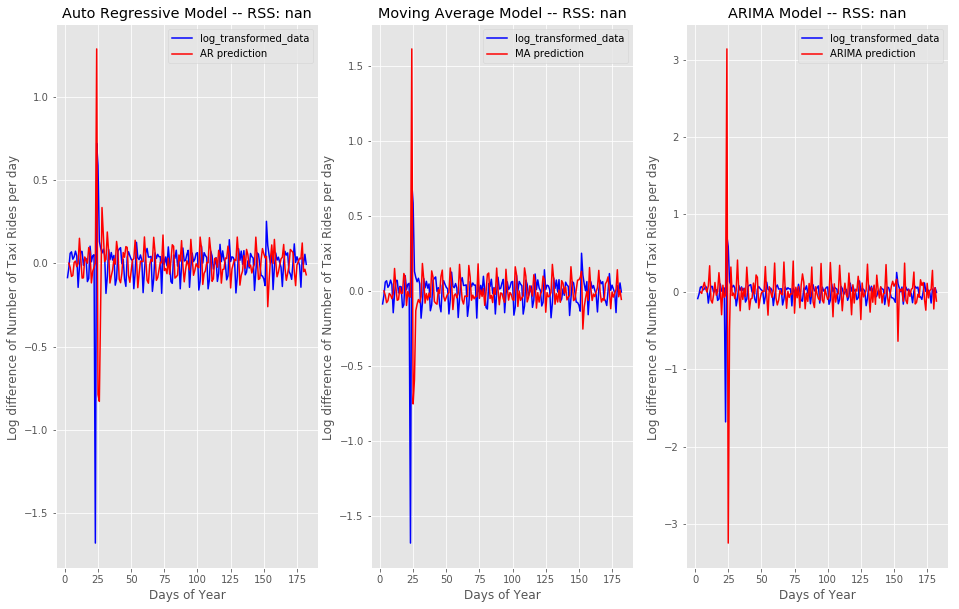

In [28]:
# AR model
# try different values of p
model1 = ARIMA(log_ts_diff, order=(3, 1, 0))  
#arguments for ARIMA order: p(AR component),d (differencing),q(MA component) 
results_AR1 = model1.fit(disp=-1)  
plt.subplot(1,3,1)
plt.plot(log_ts_diff, color = 'blue', label = 'log_transformed_data')
plt.plot(results_AR1.fittedvalues, color='red', label= 'AR prediction')
plt.title('Auto Regressive Model -- RSS: %.4f'% sum((results_AR1.fittedvalues-log_ts_diff['count'])**2))
plt.xlabel('Days of Year')
plt.ylabel('Log difference of Number of Taxi Rides per day ')
plt.legend()

# MA model
# try different values of p
model2 = ARIMA(log_ts_diff, order=(0, 1, 1))  
#arguments for ARIMA order: p(AR component),d (differencing),q(MA component) 
results_MA2 = model2.fit(disp=-1)  
plt.subplot(1,3,2)
plt.plot(log_ts_diff, color = 'blue', label = 'log_transformed_data')
plt.plot(results_MA2.fittedvalues, color='red', label= 'MA prediction')
plt.title('Moving Average Model -- RSS: %.4f'% sum((results_MA2.fittedvalues-log_ts_diff['count'])**2))
plt.xlabel('Days of Year')
plt.ylabel('Log difference of Number of Taxi Rides per day ')
plt.legend()


# ARIMA model
# try different values of p
model3 = ARIMA(log_ts_diff, order=(1,2,3))  
#arguments for ARIMA order: p(AR component),d (differencing),q(MA component) 
results_ARIMA3 = model3.fit(disp=-1)  
plt.subplot(1,3,3)
plt.plot(log_ts_diff, color = 'blue', label = 'log_transformed_data')
plt.plot(results_ARIMA3.fittedvalues, color='red', label= 'ARIMA prediction')
plt.title('ARIMA Model -- RSS: %.4f'% sum((results_ARIMA3.fittedvalues-log_ts_diff['count'])**2))
plt.xlabel('Days of Year')
plt.ylabel('Log difference of Number of Taxi Rides per day ')
plt.legend()

We can see that the RSS values of the in-sample results for all the processes were most likely so low that they were printed as NaN values. This is because at the scale that both the time series and that AR & MA fitted values occur between 0 and 1. Ultimately, the differences of those two values woudl be a negligebly small demical, which squaring will only make smaller. The sum of such small decimals are probably resulting in a NaN value for the RSS.


# Transforming ARIMA predictions back into Number of Rides

Get fittedvalues for each AR, MA, and ARIMA model

In [29]:
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

Get the cumsum() for each proceeding value (since we took the shifted difference)

In [30]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum() 
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum() 
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum() 

Add the original log value of the time series to the first index of the new predictions series. (will account for the starting place of the predictions since we lost that information during the difference transformation)

In [31]:
predictions_AR_log = pd.Series(log_ts['count'].iloc[0], index=log_ts_diff.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)

predictions_MA_log = pd.Series(log_ts['count'].iloc[0], index=log_ts_diff.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)

predictions_ARIMA_log = pd.Series(log_ts['count'].iloc[0], index=log_ts_diff.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

Raise $e$ by the new values, converting from natural log transformation

In [32]:
predictions_AR = np.exp(predictions_AR_log)
predictions_MA = np.exp(predictions_MA_log)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Plot the predictions

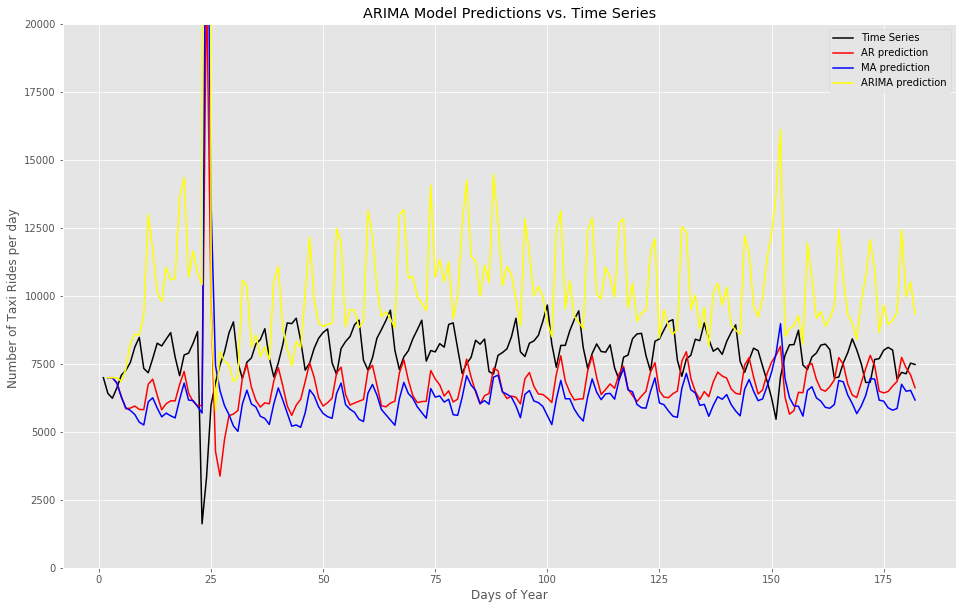

In [33]:
plt.plot(ts, color = 'black', label = 'Time Series')
plt.plot(predictions_AR, color =  'red', label = 'AR prediction')
plt.plot(predictions_MA, color = 'blue', label = 'MA prediction')
plt.plot(predictions_ARIMA, color =  'yellow', label = 'ARIMA prediction')
plt.ylim(0, 20000)  
plt.xlabel('Days of Year')
plt.ylabel('Number of Taxi Rides per day ')
plt.title('ARIMA Model Predictions vs. Time Series')
plt.legend()

We can see that all three predictions do not account for the significant dip in taxi rides of January 23rd as much as the real time series data. We can also see that both AR and MA processes slightly undershoot the number of taxi rides per day, while the ARIMA process over estimates the number of taxi rides per day by a large margin. 

The biggest error comes from the rebounding of all three models that appear right after January 23rd (the day with the significant drop in taxi rides) The models overcompensate and overestimate the next day by a large margin. 

It seesm that for our model, (as predicted) the AR process most accurately captures the trend and is the closest to the actual values of the time series. However, for all of the predicted models, the trends do not accurately line up. Just plotting a fitted regression line for the values may even end up working better at this rate.

# Seasonal ARIMA Modelling

We can use the statsmodel's SARIMAX function to model a seasonal arima model on our dataset by prescribing a set of p,d,q variables. Calling the summary method on the fitted model then gives information about the fitted model including information criterion such as AIC and BIC.

We will also take the first 95% of the dataset as our prediction values, and leave out the most recent 5% of the dataset as the prediction (test) values. We dont want to take a random split of training and test datas because in this time series, we want to see how well we can predict our out of sample "future" values for ride demand. 

In [223]:
log_ts_diff =  log_ts_diff[25:]
log_ts_diff.shape[0]

156

In [224]:
log_ts_diff.reset_index(inplace = True)

It would have to be noted here that the following model won't accurately reflect on the real world data, since I am deleting the first 25 days' worth of data, to completely rid ourselves of the anomaly that happens during January 23-25th. I believe that by removing the first 25 days of data (and with the remaining 156 data points) we can better understand the underlying seasonality and trends that occur in the number of taxi rides per day dataset. 


In [196]:
n_sample = log_ts_diff.shape[0]
print('New length of the entire dataset is : %i' %n_sample)

New length of the entire dataset is : 156


In [197]:
n_train=int(0.95*n_sample) + 1
n_forecast=n_sample-n_train

ts_train = log_ts_diff.iloc[:n_train]['count']
ts_test = log_ts_diff.iloc[n_train:]['count']

In [198]:
print(('Number of in sample training dataset : %i' %len(ts_train)))
print(('Number of out of sample testing dataset : %i' %len(ts_test)))

Number of in sample training dataset : 149
Number of out of sample testing dataset : 7


Including seasonal_order with the AR and MA component and period of 7 days (weekly). 
Simple differencing is set to true such that we can forecast and calculate the error values later on the held out "future" data


In [199]:
arima111 = sm.tsa.statespace.SARIMAX(ts_train, order=(1,0,1), seasonal_order= (1,0,1,7), simple_differencing=True)
model_results = arima111.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             count   No. Observations:                  149
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                 260.967
Date:                           Tue, 09 Jul 2019   AIC                           -511.933
Time:                                   18:09:43   BIC                           -496.913
Sample:                                        0   HQIC                          -505.831
                                           - 149                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7511      0.035     21.592      0.000       0.683       0.819
ma.L1         -0.9941      0.009   -107.927      0.000      -1.012      -0.976
ar.S.L7        0.9976      0.003    295.774      0.000       0.991       1.004
ma.S.L7       -0.8699      0.074    -11.812      0.000      -1.014      -0.726
sigma2         0.0016      0.000     11.118      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       34.68   Jarque-Bera (JB):                20.39
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               1.96   Skew:                            -0.31
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The following function will gather the BIC metric given a set of p,d,q values to try out.

In [200]:
import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

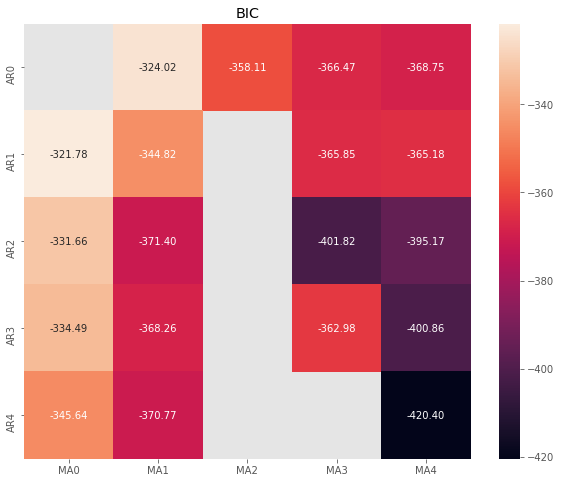

In [201]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

Plotting the above function as a heatmap, we can see that AR 1 and MA 0 gives us the lowest BIC measure out of all of the different combinations of input variables.

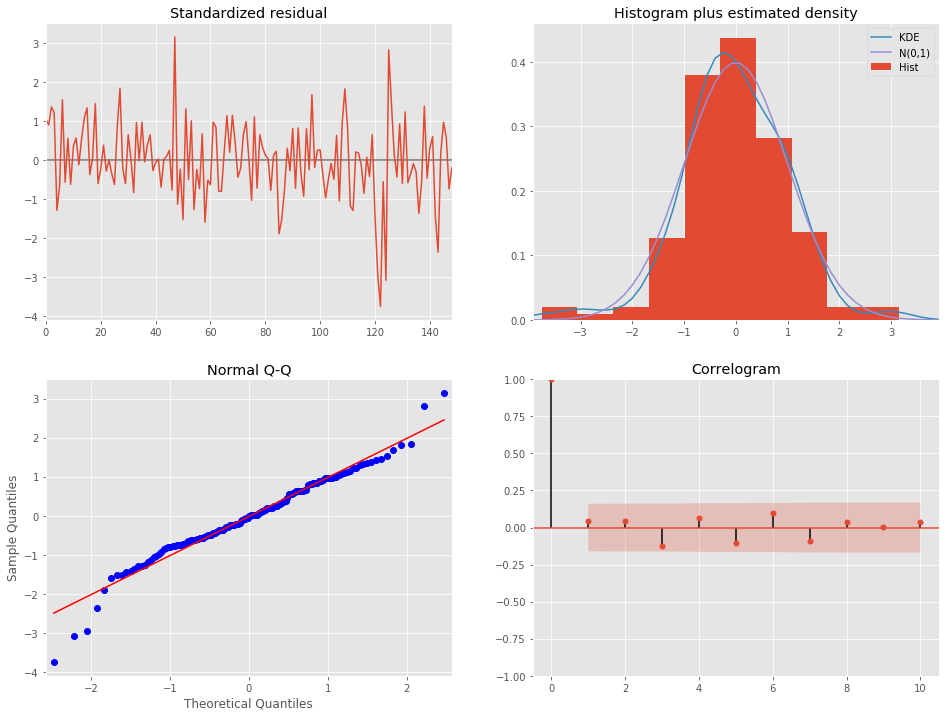

In [202]:
model_results.plot_diagnostics(figsize=(16, 12));

Finally, using the plot_diagnostic method on the model defined with AR 1 and MA 1 order components, we can see valuable featuers such as residuals, histogram, normality, and correlogram. 

For the most part, from looking at the plot distributions of the residuals from the SARIMAX model, we can see that the residuals look scattered around zero, and are roughly normally distributed when looking at the histogram and the linear fit. The correlation values mostly stay within the 95% confidence range as well. 

By taking out the first 25 days of values, we have effectively made our dataset more normally pleasant. 

In [203]:
# Re-run the above statistical tests, and more. To be used when selecting viable models.

het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

(het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # last number for the largest lag
sercor_p = sercor_p[-1] # last number for the largest lag

# Run Durbin-Watson test on the standardized residuals.
# The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
# Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
# This statistic will always be between 0 and 4. The closer to 0 the statistic,
# the more evidence for positive serial correlation. The closer to 4,
# the more evidence for negative serial correlation.
# Essentially, below 1 or above 3 is bad.
dw = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

# check whether roots are outside the unit circle (we want them to be);
# will be True when AR is not used (i.e., AR order = 0)
arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
# will be True when MA is not used (i.e., MA order = 0)
maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)

print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))


Test heteroskedasticity of residuals (breakvar): stat=1.956, p=0.019

Test normality of residuals (jarquebera): stat=20.387, p=0.000

Test serial correlation of residuals (ljungbox): stat=34.683, p=0.708

Durbin-Watson test on residuals: d=1.91
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


Judging by the results of the statistics tests carried out above, we can conclude the following:

- The null hypothesis is of no heteroskedasticity is rejected since the p value is 0.019 (at $\alpha = 0.05$)
- The test for normality of standardized residuals is rejected given the p value of 0. 
- The Jung-box test for no serial correlation of standardized residuals is not rejected 
- The Durbin-Watson test also shows no serial correlation as the value is near 2
- Both the AR and MA roots are outside of the unit circle, suggesting that our model has achieved invertibility




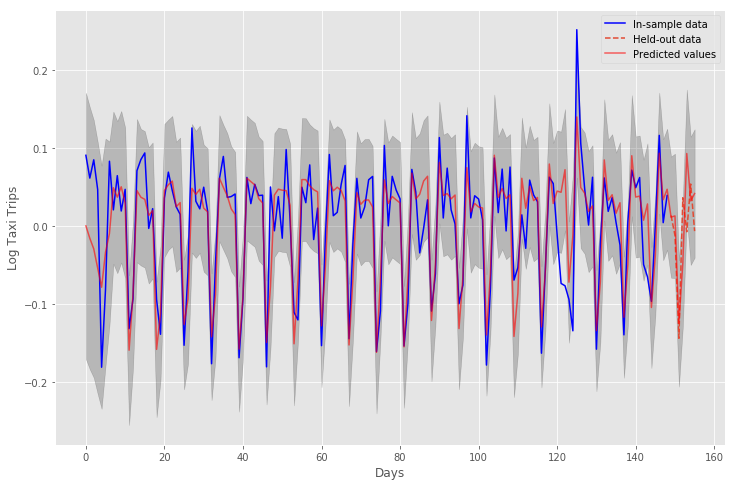

In [204]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, color = 'blue', label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin,
                                    end=pred_end)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.xlabel('Days')
plt.ylabel('Log Taxi Trips')
ax1.legend(loc='best');

In [205]:
def get_rmse(y, y_hat):

    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

In [206]:
rmse1 = get_rmse(ts_train, pred_mean.iloc[ts_train.index])
print("In sample RMLSE: %.4f" % rmse1)

rmse2 = get_rmse(ts_test, pred_mean.iloc[-7:])
print("Out of Sample forecast RMLSE: %.4f" % rmse2)


In sample RMLSE: 0.0437
Out of Sample forecast RMLSE: 0.0546


With our SARIMAX model, we achieve an in sample RMLSE error value of 0.04, while we achieve an out of sample forecast RMLSE of 0.054. While our forecast model was only 9 data samples, we get a promising result, even if it is the log squared error. 

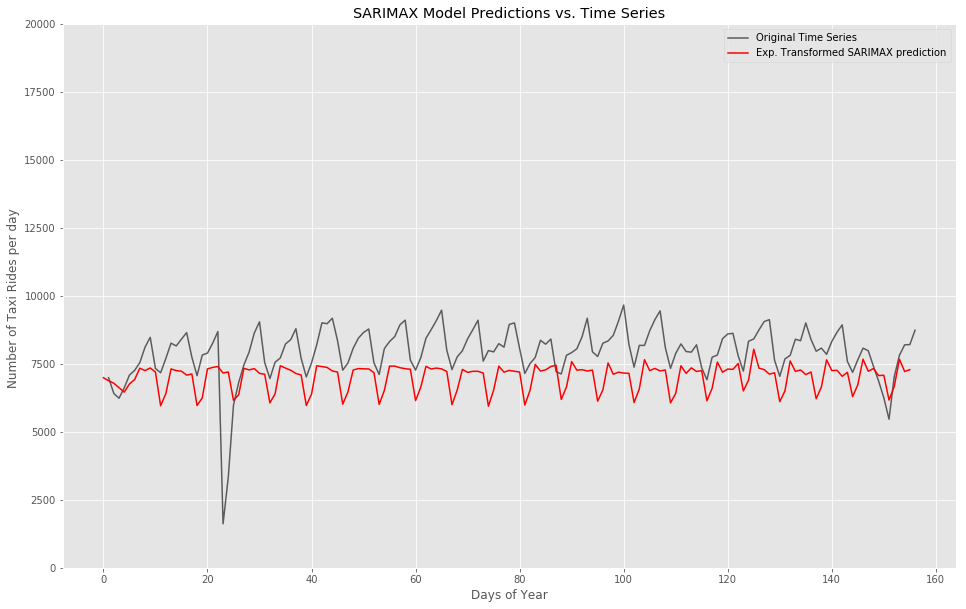

In [207]:
predictions_seasonal_log = pd.Series(log_ts['count'].iloc[0], index=pred_mean.index)
predictions_seasonal_log = predictions_seasonal_log.add(pred_mean.values,fill_value=0)
predictions_seasonal = np.exp(predictions_seasonal_log.values)

plt.plot(ts[:156], color = 'black', label = 'Original Time Series', alpha = 0.6)
plt.plot(predictions_seasonal, color =  'red', label = 'Exp. Transformed SARIMAX prediction')
plt.ylim(0, 20000)  
plt.xlabel('Days of Year')
plt.ylabel('Number of Taxi Rides per day ')
plt.title('SARIMAX Model Predictions vs. Time Series')
plt.legend()


Looking at the power transformed predictions and the original time series, we can see that the SARIMAX model was adapt at modelling the weekly seasonality present in the orginial dataset. 